In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
import os
from scipy.stats import ttest_rel
from statsmodels.stats.weightstats import ttest_ind as t
from statsmodels.stats.anova import AnovaRM
from scipy.stats import ttest_rel

In [2]:
# setting directories
## change this to the directory where you have stored the data for the project
# base_dir = "C:\\Users\\khash\\OneDrive\\Documents\\GitHub\\WM_chunking"
base_dir = "C:\\Users\\lshah\\OneDrive\\Documents\\Projects\\WM_chunking"
behav_dir = os.path.join(base_dir, "data", "behavioural", "raw")

# setting some default variables
return_subjs = ["s10", "s11", "s12", "s14", "s15", "s16", "s17", "s18", "s19", "s20", "s21", "s22", "s23", "s24", "s25"]

In [3]:
def clean_df(subject):
    """
    Takes in the subject name and does initial cleaning (removes unwanted columns)
    Args:
        subject (str) - name assigned to the subject 
    """
    
    # get subject directory
    subj_dir = os.path.join(behav_dir, subject)
    # load the dataframe
    df_sub = pd.read_csv(os.path.join(subj_dir, f'WMC_{subject}.csv'), converters={'response_time': pd.eval})
    
    # deleting the Unnamed columns
    ## get all the columns with Unnamed 
    filter_col = [col for col in df_sub if col.startswith('Unnamed')]
    ## drop all the unnamed columns
    df_sub = df_sub.drop(filter_col, axis = 1)
    
    # loop over runs and add a column representing the trial number
    runs = np.unique(df_sub.run_number.values)
    df = pd.DataFrame()
    for r in runs:
        # get the section of the dataframe corresponding to the current run
        df_run = df_sub.loc[df_sub.run_number == r].copy()
        df_run.reset_index(drop = True, inplace = True)
        TN_value = np.arange(0, len(df_run.index))
        df_run.insert(loc = 0, column='TN', value=TN_value)
        # calculate reaction times for each trial
        rt = []
        rt.append(np.nan)
        rt.append(df_run["response_time"][1][0] - 6.5)
        for t in df_run.index[2:]:
            
            if len(df_run["response_time"][t]) == 0:
                rt.append(np.nan)
            else:
                ipi_0 = df_run["response_time"][t][0] - (df_run['response_time'][t-2][5] + 6 + 0.5)
                if ipi_0 <0:
                    ipi_0 = np.nan
                rt.append(ipi_0)
                
        df_run.loc[:, "ipi_0"] = rt

        df = pd.concat([df, df_run])      
    return df

def merge_df(subject_list):
    """
    takes in a list of subjects and merge their behavioural data into 1 dataframe
    Args: 
        subject_list (list) - list containing names assigned to subjects
        
    returns:
        merged_df (pd.DataFrame) -  a dataframe with merged data for all the subjects
    """
    
    df_list = []
    i = 0
    for s in subject_list:
        
        # clean the subject data
        df_subject = clean_df(s)
        
        # add a column to the dataframe containing the subject name
        df_subject["subject"] = i
        
        # append it to the dataframes list
        df_list.append(df_subject)
        
        i = i+1
        
    # merge dataframe
    merged_df = pd.concat(df_list, axis = 0, ignore_index = True)
    
    ## drop 1234 column (not all subjects have that)
    merged_df = merged_df.drop(['1234'], axis = 1)
    
    return merged_df
#____________________________________________________________________________________________
# calculate reaction times and inter-press-intervales
def calc_rt(data):
    """
    calculates reaction time (time of the first press)
    """
    return

def calc_ipi(data):
    """
    calculates inter-press-intervals and returns a specific dataframe to plot the ipis
    Args:
        data (pd.DataFrame) - the dataframe with all the data (can be a subject's dataframe or the merged dataframe)
    Returns:
        data_ipi (pd.DataFrame) - the dataframe to be used for analysis of ipis
    """
    # get execution trials
    data_exe = data.loc[data["phase_type"] == 1]  
    # get the response times
    response_times = data_exe["response_time"]
    response_times = response_times.values.tolist()
    response_times = np.array(response_times)
    # calculate ipis for each trial
    ipis = np.diff(response_times)
    
    # convert ipis to a temporary dataframe and append it to the original dataframe
    df_ipis = pd.DataFrame(ipis, columns = [1, 2, 3, 4, 5])
    # reset indices before merging
    df_ipis.reset_index(drop = True, inplace = True)
    data_exe.reset_index(drop = True, inplace = True)
    
    # joing the two dataframes
    data_exe = data_exe.join(df_ipis) 
    
    data_tmp = data_exe[['subject', 1, 2, 3, 4, 5, 'chunk', 'recall_dir']]
    data_ipi = pd.melt(data_tmp, id_vars=['subject', 'chunk', 'recall_dir'], value_vars=[1, 2, 3, 4, 5])
    data_ipi = data_ipi.rename(columns={'variable': 'ipi', 'value': 'time'})
    data_ipi.time = data_ipi.time.astype(float)
    return data_ipi
#____________________________________________________________________________________________
# calculate accuracy and error-rate for each serial place
def calc_acc(data):
    return
def calc_acc_serial(data):
    return
#____________________________________________________________________________________________

In [4]:
df_final = merge_df(return_subjs)

In [5]:
#Get run number
run_tra = np.repeat(0,16)
x2=[1,2,3,4,5,6,7,8]
run_exp = np.repeat(x2,24)
run = np.concatenate((run_tra, run_exp))
run_num = np.tile(run, 15)
df_final['run_num'] = run_num

In [8]:
#Get accuracy based on points
df_final['points'] = df_final['points'].replace(10, 6)
accuracy = ((df_final['points']/6)*100)
df_final['%_ACC']= accuracy
df_final
# out_dir = os.path.join(base_dir, "data", "behavioral", "raw")
# df_final.to_csv(os.path.join(out_dir, "Final_data.csv"))

,TN,MT,chunk,display_trial_feedback,feedback_dur,feedback_type,hand,is_error,item_dur,iti_dur,...,response,response_time,run_number,seq_length,seq_str,trial_dur,ipi_0,subject,run_num,%_ACC
0,0,0.000000,3,False,0.0,None,right,False,2,1,...,[],[],1,6,2 2 2 4 4 3,6,NaN,0,0,0.000000
1,1,4.552014,3,True,0.5,acc,right,False,2,1,...,"['2', '2', '2', '4', '4', '3']","[7.077982099988731, 7.373946499981685, 7.65442...",1,6,# # # # # #,None,0.577982,0,0,100.000000
2,2,0.000000,3,False,0.0,None,right,False,2,1,...,[],[],1,6,1 3 1 3 1 2,6,NaN,0,0,0.000000
3,3,3.224033,3,True,0.5,acc,right,False,2,1,...,"['1', '3', '1', '3', '1', '2']","[18.654032499995083, 19.87775970000075, 20.253...",1,6,# # # # # #,None,0.524036,0,0,100.000000
4,4,0.000000,3,False,0.0,None,right,False,2,1,...,[],[],1,6,4 1 4 3 4 3,6,NaN,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,19,1.647912,3,True,0.5,acc,right,False,2,1,...,"['1', '1', '3', '2', '2', '1']","[102.9525272000028, 103.25639690000389, 103.67...",8,6,# # # # # #,None,NaN,14,8,100.000000
3116,20,0.000000,3,False,0.0,None,right,False,2,1,...,[],[],8,6,2 3 1 1 3 4,6,NaN,14,8,0.000000
3117,21,2.039866,3,True,0.5,acc,right,True,2,1,...,"['4', '3', '1', '3', '1', '2']","[111.88051640000776, 112.47240460000467, 112.9...",8,6,# # # # # #,None,0.780077,14,8,66.666667
3118,22,0.000000,3,False,0.0,None,right,False,2,1,...,[],[],8,6,4 3 2 2 1 3,6,NaN,14,8,0.000000


In [9]:
#Exclude training, incorrect trials, encoding phase

df = df_final.loc[(df_final['phase_type'] == 1) & (df_final['is_error'] == False) & (df_final['run_num'] != 0)]
aa = calc_ipi(df)
aa_bw = aa.loc[aa.recall_dir == 0]
aa_fw = aa.loc[aa.recall_dir == 1]

In [10]:
aa_bw_2 = aa_bw.loc[aa_bw.chunk == 2]
display(aa_bw_2)
results = ttest_rel(aa_bw_2.loc[aa_bw_2.ipi == 2], aa_bw_2.loc[aa_bw_2.ipi == 4], nan_policy = 'omit')

,subject,chunk,recall_dir,ipi,time
1,0,2,0,1,0.463966
3,0,2,0,1,1.095934
8,0,2,0,1,0.207909
13,0,2,0,1,0.879909
16,0,2,0,1,0.208453
...,...,...,...,...,...
4580,14,2,0,5,0.175827
4586,14,2,0,5,0.311951
4588,14,2,0,5,0.296034
4592,14,2,0,5,0.239906


In [11]:
df_acc = df_final.loc[(df_final['run_num'] != 0) & (df_final['phase_type'] == 1)]
df_acc2 = df_final.loc[(df_final['phase_type'] == 1)]

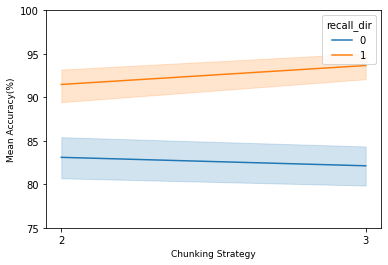

In [13]:
sns.lineplot(x="chunk", y="%_ACC", hue="recall_dir", data= df_acc)
plt.xlabel(r'Chunking Strategy', fontsize=9)
plt.ylabel(r'Mean Accuracy(%)', fontsize=9)
plt.ylim(75, 100)
plt.xlim(2,3)
plt.autoscale(enable=True, axis='x', tight=False)
plt.locator_params(axis='x', nbins=1)
# plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\Line_AC.pdf", dpi=600)

In [14]:
aovrm = AnovaRM(df_acc, '%_ACC', 'subject', within=['chunk', 'recall_dir'], aggregate_func='mean')
res = aovrm.fit()
print(res)

                    Anova
                 F Value Num DF  Den DF Pr > F
----------------------------------------------
chunk             0.2469 1.0000 14.0000 0.6269
recall_dir       20.7987 1.0000 14.0000 0.0004
chunk:recall_dir  2.4249 1.0000 14.0000 0.1417



In [ ]:
#df_acc_fw_2 = df_acc.loc[(df_acc['recall_dir'] == '1') & (df_acc['chunk'] == '2')]
#df_acc_fw_3 = df_acc.loc[(df_acc['recall_dir'] == '1') & (df_acc['chunk'] == '3')]
#df_acc_bw_2 = df_acc.loc[(df_acc['recall_dir'] == '0') & (df_acc['chunk'] == '2')]
#df_acc_bw_3 = df_acc.loc[(df_acc['recall_dir'] == '0') & (df_acc['chunk'] == '3')]
#print(t(df_acc_fw_2, df_acc_fw_3, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

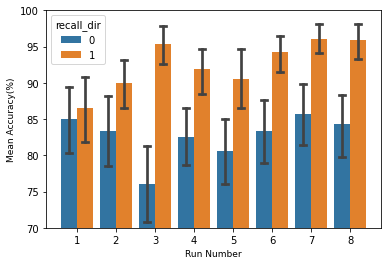

In [23]:
fig, ax = plt.subplots()
sns.barplot(x="run_num", y="%_ACC", hue="recall_dir", capsize=0.15, data= df_acc)
plt.xlabel(r'Run Number', fontsize=9)
plt.ylabel(r'Mean Accuracy(%)', fontsize=9)
plt.ylim(70, 100)
plt.xlim(2,3)
plt.autoscale(enable=True, axis='x', tight=False)
# plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\Accuracy_run.pdf", dpi=600)

C2_BW_i1 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_1'), ['time']]
C2_BW_i2 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_2'), ['time']]
C2_BW_i3 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_3'), ['time']]
C2_BW_i4 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_4'), ['time']]
C2_BW_i5 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_5'), ['time']]

C2_FW_i1 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_1'), ['time']]
C2_FW_i2 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_2'), ['time']]
C2_FW_i3 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_3'), ['time']]
C2_FW_i4 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_4'), ['time']]
C2_FW_i5 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_5'), ['time']]

C3_BW_i1 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_1'), ['time']]
C3_BW_i2 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_2'), ['time']]
C3_BW_i3 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_3'), ['time']]
C3_BW_i4 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_4'), ['time']]
C3_BW_i5 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_5'), ['time']]

C3_FW_i1 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_1'), ['time']]
C3_FW_i2 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_2'), ['time']]
C3_FW_i3 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_3'), ['time']]
C3_FW_i4 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_4'), ['time']]
C3_FW_i5 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_5'), ['time']]

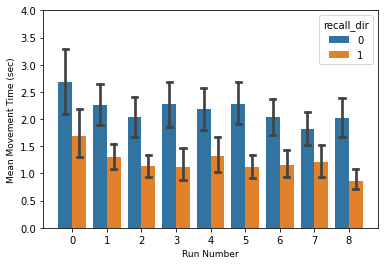

In [24]:
fig, ax = plt.subplots()
sns.barplot(x="run_num", y="MT", hue="recall_dir",capsize=0.15, data= df_final)
plt.xlabel(r'Run Number', fontsize=9)
plt.ylabel(r'Mean Movement Time (sec)', fontsize=9)
plt.ylim(0, 4)
plt.xlim(2,3)
plt.autoscale(enable=True, axis='x', tight=False)
# plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\MT_run.pdf", dpi=600)

In [25]:
Chunk2 = aa.loc[(aa['chunk'] == 2)  , ['subject', 'chunk', 'recall_dir', 'ipi','time']]
Chunk3 = aa.loc[(aa['chunk'] == 3)  , ['subject', 'chunk', 'recall_dir', 'ipi','time']]

C2_BW_i1 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 1), ['time']]
C2_BW_i2 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 2), ['time']]
C2_BW_i3 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 3), ['time']]
C2_BW_i4 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 4), ['time']]
C2_BW_i5 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 5), ['time']]

C2_FW_i1 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 1), ['time']]
C2_FW_i2 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 2), ['time']]
C2_FW_i3 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 3), ['time']]
C2_FW_i4 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 4), ['time']]
C2_FW_i5 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 5), ['time']]

C3_BW_i1 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 1), ['time']]
C3_BW_i2 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 2), ['time']]
C3_BW_i3 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 3), ['time']]
C3_BW_i4 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 4), ['time']]
C3_BW_i5 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 5), ['time']]

C3_FW_i1 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 1), ['time']]
C3_FW_i2 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 2), ['time']]
C3_FW_i3 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 3), ['time']]
C3_FW_i4 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 4), ['time']]
C3_FW_i5 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 5), ['time']]

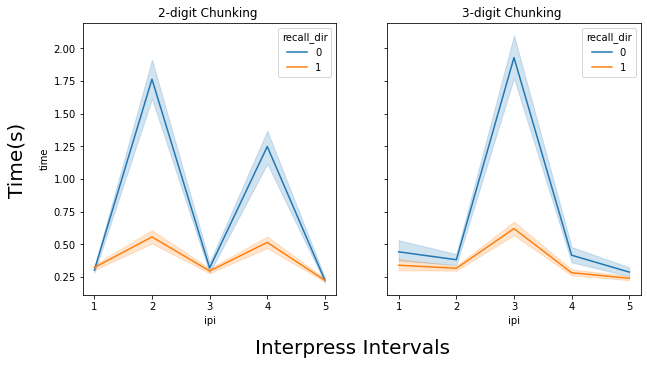

In [26]:
figure, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
sns.lineplot(ax=axes[0], data = Chunk2, hue = "recall_dir", x = "ipi", y = "time", color='r')
sns.lineplot(ax=axes[1], data = Chunk3, hue = "recall_dir", x = "ipi", y = "time", color='b')

figure.supylabel(r'Time(s)', x = 0.02, fontsize=20)
figure.supxlabel(r'Interpress Intervals', y= -0.05, fontsize=20)
    
axes[0].title.set_text(r'2-digit Chunking ')
axes[1].title.set_text(r'3-digit Chunking ')
# plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\ipi_plot.pdf", dpi=600)

In [88]:
# display(aa)
"""
First, we need to create a table that has the average time for each ipis for each subject
The goal is to average the ipi for each condition type across trials for each subject.
For that, we use pandas pivot table
"""
d = pd.pivot_table(aa, values='time', index='subject', columns=['chunk', 'recall_dir', 'ipi'], aggfunc=np.mean) # 'X_data'
"""
Next, we transpose the dataframe. This is only done to make coding easier  as d is a multi-level dataframe
and it'll be tricky to get a certain column from it.
After transposing, different condition types will be places on rows and it will be easy to use
.loc to get the column that we want
"""
DD = d.T
"""
Now, take a look at DD
"""
display(DD)

"""
we will use .loc to get the data for our t-test
For example, say we want to see whether in chunking 2 (chunk = 2), backwards(recall_dir = 0),
ipi 2(ipi = 2) is signigicantly higher than ipi 4(ipi = 4).
AA = DD.loc[2, 0, 2] chunking 2, backwards, ipi 2
BB = DD.loc[2, 0, 4] chunking 2, backwards, ipi 4
"""
AA = DD.loc[2, 0, 2]
BB = DD.loc[2, 0, 4]

"""
Now you need to do a paired t-test between AA and BB.
For that, we use ttest_rel from scipy.stats package
"""
result = ttest_rel(AA, BB, nan_policy='omit')
print(result)

"""
Follow the same procedure to do all your testings
"""

subject                     0         1         2         3         4   \
chunk recall_dir ipi                                                     
2     0          1    0.295488  0.355285  0.291090  0.187215  0.303556   
                 2    2.310946  2.947691  0.822446  2.391584  1.511928   
                 3    0.327515  0.343887  0.268787  0.214614  0.246492   
                 4    1.481039  1.499543  0.840047  1.558961  1.414976   
                 5    0.121010  0.212471  0.214313  0.146481  0.142006   
      1          1    0.285701  0.359956  0.316905  0.316531  0.280596   
                 2    0.900184  0.443771  0.399113  0.705264  0.382361   
                 3    0.160401  0.337046  0.347112  0.247517  0.221366   
                 4    0.839591  0.579767  0.329317  0.580888  0.459662   
                 5    0.104006  0.244781  0.230236  0.180104  0.160699   
3     0          1    0.514693  0.340537  0.276845  0.560920  0.297083   
                 2    0.465017  0.261779  0.292799  0.307295  0.298159   
                 3    2.276276  2.520148  1.665565  2.395694  1.956877   
                 4    0.648526  0.330344  0.236876  0.335198  0.210571   
                 5    0.379833  0.246632  0.211113  0.190070  0.187746   
      1          1    0.272800  0.255982  0.259260  0.342620  0.389556   
                 2    0.267593  0.260460  0.230117  0.304439  0.300179   
                 3    0.819628  0.486739  0.487072  0.900890  0.708965   
                 4    0.249594  0.228403  0.212260  0.251971  0.290748   
                 5    0.214398  0.198625  0.181620  0.226726  0.228976   

subject                     5         6         7         8         9   \
chunk recall_dir ipi                                                     
2     0          1    0.354753  0.281136  0.260294  0.204116  0.401342   
                 2    1.303978  1.523327  1.666585  1.012166  2.018620   
                 3    0.266338  0.441398  0.364677  0.253778  0.348112   
                 4    1.410326  1.357748  1.127196  0.882114  1.054734   
                 5    0.217598  0.258257  0.270035  0.291778  0.446526   
      1          1    0.343264  0.337043  0.210994  0.315600  0.356266   
                 2    0.667896  0.641710  0.421021  0.571328  0.933326   
                 3    0.321717  0.313101  0.222282  0.314841  0.371802   
                 4    0.761428  0.439965  0.430407  0.456006  0.695405   
                 5    0.257548  0.239517  0.198242  0.233315  0.380302   
3     0          1    0.736227  0.363579  0.275016  0.295589  0.580277   
                 2    0.447192  0.420553  0.288930  0.266719  0.640025   
                 3    1.954012  1.291042  1.565983  0.898937  2.134748   
                 4    0.506257  0.678008  0.361542  0.253070  0.522420   
                 5    0.272213  0.310571  0.268490  0.242672  0.598853   
      1          1    0.351520  0.326359  0.301119  0.535492  0.371832   
                 2    0.443935  0.263287  0.266178  0.303886  0.507136   
                 3    0.921916  0.461196  0.482133  0.398489  0.956227   
                 4    0.278414  0.309617  0.373442  0.272770  0.389353   
                 5    0.285448  0.242132  0.234273  0.231473  0.398897   

subject                     10        11        12        13        14  
chunk recall_dir ipi                                                    
2     0          1    0.266398  0.196672  0.377037  0.314222  0.435915  
                 2    1.631263  1.303204  2.093869  1.749745  1.042478  
                 3    0.231174  0.200671  0.352704  0.276233  0.571241  
                 4    0.648782  1.270644  1.207636  1.346691  0.875994  
                 5    0.207259  0.166152  0.246969  0.225091  0.381715  
      1          1    0.279934  0.248305  0.437970  0.292872  0.467173  
                 2    0.308019  0.431314  0.500956  0.479694  0.514669  
                 3    0.233049  0.293477  0.400502  0.283413  0.386132  
            

Ttest_relResult(statistic=4.033806515563584, pvalue=0.0012316873325790335)


'\nFollow the same procedure to do all your testings\n'

In [27]:
#Is Chunking Happening
#BW 2- digit Chunking
print(t(C2_BW_i2, C2_BW_i1, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C2_BW_i2, C2_BW_i3, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C2_BW_i4, C2_BW_i3, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C2_BW_i4, C2_BW_i5, alternative='larger', usevar='pooled', weights=(None, None), value=0))

#FW 2- digit Chunking
print(t(C2_FW_i2, C2_FW_i1, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C2_FW_i2, C2_FW_i3, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C2_FW_i4, C2_FW_i3, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C2_FW_i4, C2_FW_i5, alternative='larger', usevar='pooled', weights=(None, None), value=0))

#BW 3- digit Chunking
print(t(C3_BW_i3, C3_BW_i2, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C3_BW_i3, C3_BW_i4, alternative='larger', usevar='pooled', weights=(None, None), value=0))

#FW 3- digit Chunking
print(t(C3_FW_i3, C3_FW_i2, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C3_FW_i3, C3_FW_i4, alternative='larger', usevar='pooled', weights=(None, None), value=0))

#Chunking is Happening

(array([18.41713755]), array([2.15772084e-55]), 394.0)
(array([17.81685224]), array([8.28441041e-53]), 394.0)
(array([14.15150485]), array([2.37462467e-37]), 394.0)
(array([16.19876768]), array([6.77476868e-46]), 394.0)
(array([8.28080663]), array([5.28552706e-16]), 516.0)
(array([9.37046388]), array([1.12313052e-19]), 516.0)
(array([8.5060298]), array([9.79022993e-17]), 516.0)
(array([11.7619712]), array([9.21241309e-29]), 516.0)
(array([17.79715076]), array([1.39523175e-51]), 360.0)
(array([16.78376426]), array([2.06554957e-47]), 360.0)
(array([10.41936194]), array([1.15795191e-23]), 562.0)
(array([11.33437107]), array([2.91265064e-27]), 562.0)


In [ ]:
#which model is better?
# 2-digit (IPI2 Vs. IPI4)

print(t(C2_BW_i2, C2_BW_i4, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C2_FW_i2, C2_FW_i4, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

In [33]:
# 3-digit (IPI1 Vs. IPI2)(IPI4 Vs. IPI5)

print(t(C3_BW_i1, C3_BW_i2, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C3_FW_i1, C3_FW_i2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C3_BW_i4, C3_BW_i5, alternative='larger', usevar='pooled', weights=(None, None), value=0))
print(t(C3_FW_i4, C3_FW_i5, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

(array([1.33562813]), array([0.09125732]), 360.0)
(array([0.95573182]), array([0.33961866]), 562.0)
(array([3.58260983]), array([0.00019348]), 360.0)
(array([3.0012678]), array([0.00280794]), 562.0)


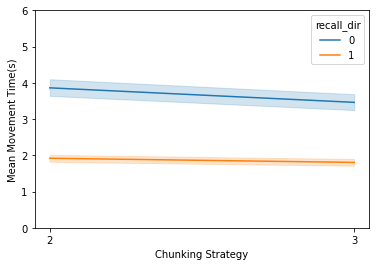

In [37]:
fig, ax = plt.subplots()
sns.lineplot(x="chunk", y="MT", hue="recall_dir", data= df)
plt.xlabel(r'Chunking Strategy', fontsize=10)
plt.ylabel(r'Mean Movement Time(s)', fontsize=10)
plt.ylim(0, 6)
plt.xlim(2,3)
plt.autoscale(enable=True, axis='x', tight=False)
plt.locator_params(axis='x', nbins=1)
# plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\Line_MT.pdf", dpi=600)

In [38]:
aovrm = AnovaRM(df, 'MT', 'subject', within=['chunk', 'recall_dir'], aggregate_func='mean')
res = aovrm.fit()
print(res)

                     Anova
                 F Value  Num DF  Den DF Pr > F
-----------------------------------------------
chunk              9.2528 1.0000 14.0000 0.0088
recall_dir       138.3384 1.0000 14.0000 0.0000
chunk:recall_dir   3.1352 1.0000 14.0000 0.0984



In [39]:
Chunk2_BW = df.loc[(df['chunk'] == 2) & (df['recall_dir'] == 0) & (df['MT'] != 0), ['MT']]
Chunk2_FW = df.loc[(df['chunk'] == 2) & (df['recall_dir'] == 1) & (df['MT'] != 0), ['MT']]
Chunk3_BW = df.loc[(df['chunk'] == 3) & (df['recall_dir'] == 0) & (df['MT'] != 0), ['MT']]
Chunk3_FW = df.loc[(df['chunk'] == 3) & (df['recall_dir'] == 1) & (df['MT'] != 0), ['MT']]

print(t(Chunk2_BW, Chunk2_FW, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(Chunk3_BW, Chunk3_FW, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(Chunk2_BW, Chunk3_BW, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(Chunk2_FW, Chunk3_FW, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

(array([16.72051922]), array([2.85232197e-49]), 455.0)
(array([15.50027054]), array([6.43933121e-44]), 461.0)
(array([2.4694332]), array([0.01397499]), 377.0)
(array([1.69566454]), array([0.09052691]), 539.0)


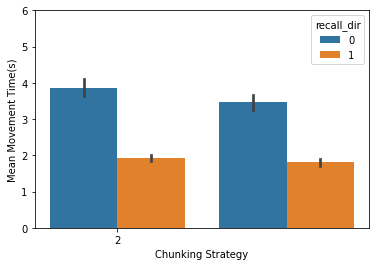

In [41]:
fig, ax = plt.subplots()
sns.barplot(x="chunk", y="MT", hue="recall_dir", data= df)
plt.xlabel(r'Chunking Strategy', fontsize=10)
plt.ylabel(r'Mean Movement Time(s)', fontsize=10)
plt.ylim(0, 6)
plt.xlim(2,3)
plt.autoscale(enable=True, axis='x', tight=False)
plt.locator_params(axis='x', nbins=1)
# plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\1.pdf", dpi=600)

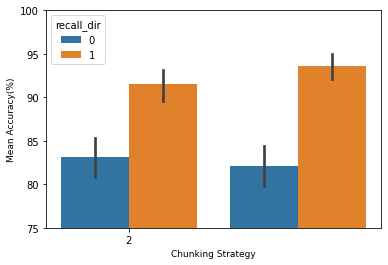

In [43]:
sns.barplot(x="chunk", y="%_ACC", hue="recall_dir", data= df_acc)
plt.xlabel(r'Chunking Strategy', fontsize=9)
plt.ylabel(r'Mean Accuracy(%)', fontsize=9)
plt.ylim(75, 100)
plt.xlim(2,3)
plt.autoscale(enable=True, axis='x', tight=False)
plt.locator_params(axis='x', nbins=1)
# plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\2.pdf", dpi=600)